In [ ]:
# Date: May 22, 2022
# Author: Kerry Tarrant

## Notes
# Code adapted from advanced machine learning course spring 2022.
# Used for displaying volume trajectory when varying parameters.

# Downloading data from Gitlab repo

If permissible, the below cell will download the data to your current directory as a MATLAB file.

Data can be downloaded using the following link:
https://research-git.uiowa.edu/kdtarrant/ece-5995-project-2022/-/raw/main/data/rtv-data-1530-32922.mat?raw=true



In [ ]:
# wget downloads data as a MATLAB file from gitlab repo. ?raw=true downloads the file and not the webpage.
!wget https://research-git.uiowa.edu/kdtarrant/ece-5995-project-2022/-/raw/main/data/5-70-5_r_04292022.mat?raw=true
!wget https://research-git.uiowa.edu/kdtarrant/ece-5995-project-2022/-/raw/main/data/5-70-5_t_04292022.mat?raw=true
!wget https://research-git.uiowa.edu/kdtarrant/ece-5995-project-2022/-/raw/main/data/5-70-5_v_04292022.mat?raw=true

# rename the file to data.mat
!mv 5-70-5_r_04292022.mat?raw=true rdata.mat
!mv 5-70-5_t_04292022.mat?raw=true tdata.mat
!mv 5-70-5_v_04292022.mat?raw=true vdata.mat


--2022-05-26 17:13:09--  https://research-git.uiowa.edu/kdtarrant/ece-5995-project-2022/-/raw/main/data/5-70-5_r_04292022.mat?raw=true
Resolving research-git.uiowa.edu (research-git.uiowa.edu)... 128.255.21.36
Connecting to research-git.uiowa.edu (research-git.uiowa.edu)|128.255.21.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 474619 (463K) [application/octet-stream]
Saving to: ‘5-70-5_r_04292022.mat?raw=true’

5-70-5_r_04292022.m 100%[===================>] 463.50K  --.-KB/s    in 0.08s   

2022-05-26 17:13:09 (5.74 MB/s) - ‘5-70-5_r_04292022.mat?raw=true’ saved [474619/474619]

--2022-05-26 17:13:09--  https://research-git.uiowa.edu/kdtarrant/ece-5995-project-2022/-/raw/main/data/5-70-5_t_04292022.mat?raw=true
Resolving research-git.uiowa.edu (research-git.uiowa.edu)... 128.255.21.36
Connecting to research-git.uiowa.edu (research-git.uiowa.edu)|128.255.21.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 658233302 (628M) [appli

# Initializing

In [ ]:
from numpy.core.numeric import argwhere
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
from sklearn.model_selection import train_test_split

from random import randrange

# tensor.to(device) to compute tensors on cuda instead of cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# A paths is defined for saving models
PATH = 'best_net.pth'
PATH_auto = 'best_auto.pth'

def transpose_array(v1 # array
                   ):
    if len(v1[:,0]) < len(v1[0,:]):
        v1T = v1.T
        return v1T
    else:
        return v1

# Grabs arrays from mat files
def mat_to_array1(mat_file, # file name
                 ar1        # name of array
                 ):
    from scipy import io
    v = io.loadmat(mat_file)
    return transpose_array(v[ar1])

# Grabs arrays from mat files
def mat_to_array3(mat_file, # file name
                 ar1,      # name of array
                 ar2,      # name of array
                 ar3       # name of array
                 ):
    from scipy import io
    v = io.loadmat(mat_file)
    return transpose_array(v[ar1]), transpose_array(v[ar2]), transpose_array(v[ar3])

# Collects the number of steps from ODE solver
def index_length(time, # array
                 ):
    Ndata = len(time[:,0])
    indices_len = np.zeros(Ndata, dtype=int)
    for i in range(Ndata):
        indices_len[i]=sum(1 for n in time[i,:] if n != 0)
    return indices_len

# Interpolates volume soltuions
def interpolate_raw(time,       # array
                    vol,        # array
                    indices_len # array
                    ):
    Ndata = len(time[:,0])
    Nmax = np.max(indices_len)
    inter_vol = np.zeros((Ndata,Nmax))
    inter_time = np.linspace(time[0,0],
                             time[0,indices_len[0]],
                             Nmax)
    for i in range(Ndata):
        inter_vol[i,:] = np.interp(inter_time.flatten(), 
                                time[i,:indices_len[i]+1].flatten(), 
                                vol[i,:indices_len[i]+1].flatten())
    return inter_vol, inter_time

# Transposes features, tosses volume higher than threshold, shuffles feat/vol
def transpose_toss_shuffle(features, # array
                           target_1, # array
                           target_2=None,  # array
                           threshold=None  # float
                           ):
    import random
    np.random.seed(32)
    if type(target_2)==type(None):
        if len(target_1.flatten()) == len(features[:,0]):
            target_1 = np.reshape(target_1,(-1,1))     # Reshape target
        mask = np.argwhere(target_1[:,-1]<threshold)   # Mask
        np.random.shuffle(mask)                        # Shuffle
        return features[mask.flat,:], target_1[mask.flat,:]
    else:
        if len(target_1.flatten()) == len(features[:,0]):
            target_1 = np.reshape(target_1,(-1,1))     # Reshape target 1
        if len(target_2.flatten()) == len(features[:,0]):
            target_2 = np.reshape(target_2,(-1,1))     # Reshape target 2
        mask = np.argwhere(target_1[:,-1]<threshold)   # Mask
        np.random.shuffle(mask)                        # Shuffle
        return features[mask.flat,:], target_1[mask.flat,:], target_2[mask.flat,:]

# Shuffles features
def shuffle_input(features,
                  Ndata):
    import random
    if len(features[:,0]) < len(features[0,:]):
            featuresT = features.T                      # Transpose features
    indices = np.array(range(Ndata))
    np.random.shuffle(indices)
    return features[indices.flat,:]

# Split data into training, testing, and validation groups
def train_test_validate_split(features,      # array
                              target_1,      # array
                              train_size,    # float in (0,1)
                              test_size,     # float in (0,train_size)
                              target_2=None # array
                              ):    
    if type(target_2)==type(None):
        X_train, X_test, X_validate = np.split(features, 
                                            [int(train_size*len(features)), 
                                            int((train_size+test_size)*len(features))])
        y_train, y_test, y_validate = np.split(target_1, 
                                            [int(train_size*len(target_1)), 
                                            int((train_size+test_size)*len(target_1))])
        return X_train, X_test, X_validate, y_train, y_test, y_validate
    else:
        X_train, X_test, X_validate = np.split(features, 
                                            [int(train_size*len(features)), 
                                            int((train_size+test_size)*len(features))])
        y1_train, y1_test, y1_validate = np.split(target_1, 
                                            [int(train_size*len(target_1)), 
                                            int((train_size+test_size)*len(target_1))])
        y2_train, y2_test, y2_validate = np.split(target_1, 
                                            [int(train_size*len(target_1)), 
                                            int((train_size+test_size)*len(target_1))])
        return X_train, X_test, X_validate, y1_train, y1_test, y1_validate, y2_train, y2_test, y2_validate

# Find the index of the original parameters when parameters in array have been shuffeled
def find_parameter_arg(parms_array, parameter_point):
    for k in range(len(parms_array[:,0])):
        ttttt = parms_array[k,:]==parameter_point
        i=0
        for tf in ttttt:
            if tf == True:
                i+=1
        if i==len(parameter_point):
            break
        
    return k


In [ ]:
# load the MATLAB file into this notebook as numpy arrays
all_yo_rates = mat_to_array1('rdata.mat',
                            'yo_rates'
                            )

all_time = mat_to_array1('tdata.mat',
                        'time0'
                        )

all_volumes = mat_to_array1('vdata.mat',
                        'volumes0',
                        )


In [ ]:
# total number of samples
Ndata_int = np.size(all_yo_rates, 0)

# gets the number of time steps for each case
len_volume_steps_array = index_length(all_time)

## Normalize and interpolate volume

In [ ]:
# Normalize volume with respect to the initial volume
intial_volume = 5.23598775598299e-13 # in initial volume in dm^3 (L)
normalized_volume = 100*all_volumes/intial_volume


In [ ]:
# Interpolating all volume solutions
inter_vol, inter_time = interpolate_raw(all_time,
                                        normalized_volume,
                                        len_volume_steps_array)


### Plot interpolated volume

In [ ]:
# Greatest number of steps
max_steps = np.max(len_volume_steps_array)
max_steps_index = np.argwhere(len_volume_steps_array==max_steps)[0][0]

min_steps = np.min(len_volume_steps_array)
min_steps_index = np.argwhere(len_volume_steps_array==min_steps)[0][0]

if 0==1:

    # Plotting interpolated volume
    plt.figure(figsize=(9,3))
    plt.plot(inter_time/3600, 
            inter_vol[max_steps_index,:].flatten(), 
            'r--', label='Interpolation', linewidth=2)
    plt.plot(all_time[max_steps_index,:len_volume_steps_array[max_steps_index]+1]/3600, 
            normalized_volume[max_steps_index,:len_volume_steps_array[max_steps_index]+1], 
            'g-', label='Actual', linewidth=2)
    plt.legend(loc='upper right', shadow=True, fontsize='medium')
    plt.title('Interpolation of volume example')
    plt.show()

    plt.figure(figsize=(9,3))
    plt.plot(inter_time/3600, 
            inter_vol[min_steps_index,:].flatten(), 
            'r--', label='Interpolation', linewidth=2)
    plt.plot(all_time[min_steps_index,:len_volume_steps_array[min_steps_index]+1]/3600, 
            normalized_volume[min_steps_index,:len_volume_steps_array[min_steps_index]+1], 
            'g-', label='Actual', linewidth=2)
    plt.legend(loc='upper right', shadow=True, fontsize='medium')
    plt.title('Interpolation of volume example')
    plt.show()

    for j in range(5):
        i = randrange(Ndata_int)
        plt.figure(figsize=(9,3))
        plt.plot(inter_time/3600, 
                inter_vol[i,:].flatten(), 
                'r--', label='Interpolation', linewidth=2)
        plt.plot(all_time[i,:len_volume_steps_array[i]+1]/3600, 
                normalized_volume[i,:len_volume_steps_array[i]+1], 
                'g-', label='Actual', linewidth=2)
        plt.legend(loc='upper right', shadow=True, fontsize='medium')
        plt.title('Interpolation of volume example')
        plt.show()


## Add a threshold to volume

Set criteria to 

```
vol_threshold = float('inf')
```
if you would like to include all collected volumes.

In [ ]:
# Criteria
vol_threshold = float('inf') # Upper bound for final volume

# Shuffling and tossing data
X, sol = transpose_toss_shuffle(features=all_yo_rates,
                                      target_1=inter_vol,
                                      target_2=None,  
                                      threshold=vol_threshold)

# Parameter values tested

X is an array with Ndata rows and 5 columns.

Column 1: Impermeant extracellular concentration

Column 2: NKA pump rate

Column 3: NKCC cotransporter rate

Column 4: KCC cotransporter rate

Column 5: NCC cotransporter rate


In [ ]:
print('Extracellular concentrations\n',all_yo_rates[np.linspace(0,int(5*20**4 - 20),5,dtype=int).flatten(),1],'\n')
print('Rates for NKA pump\n',all_yo_rates[np.linspace(0,int(20**4 - 20),20,dtype=int).flatten(),1],'\n')
print('Rates for NKCC cotransporter\n',all_yo_rates[np.linspace(0,int(20**3 - 20),20,dtype=int).flatten(),2],'\n')
print('Rates for KCC cotransporter\n',all_yo_rates[np.linspace(0,int(20**2 - 20),20,dtype=int).flatten(),3],'\n')
print('Rates for NCC cotransporter\n',all_yo_rates[:20,4],'\n')

Extracellular concentrations
 [0.00000000e+00 3.63763360e-07 8.18467560e-07 1.27317176e-06
 1.72787596e-06] 

Rates for NKA pump
 [0.00000000e+00 9.09408400e-08 1.81881680e-07 2.72822520e-07
 3.63763360e-07 4.54704200e-07 5.45645040e-07 6.36585880e-07
 7.27526720e-07 8.18467560e-07 9.09408400e-07 1.00034924e-06
 1.09129008e-06 1.18223092e-06 1.27317176e-06 1.36411260e-06
 1.45505344e-06 1.54599428e-06 1.63693512e-06 1.72787596e-06] 

Rates for NKCC cotransporter
 [0.00000000e+00 1.81881680e-08 3.63763360e-08 5.45645040e-08
 7.27526720e-08 9.09408400e-08 1.09129008e-07 1.27317176e-07
 1.45505344e-07 1.63693512e-07 1.81881680e-07 2.00069848e-07
 2.18258016e-07 2.36446184e-07 2.54634352e-07 2.72822520e-07
 2.91010688e-07 3.09198856e-07 3.27387024e-07 3.45575192e-07] 

Rates for KCC cotransporter
 [0.00000000e+00 8.26734909e-11 1.65346982e-10 2.48020473e-10
 3.30693964e-10 4.13367454e-10 4.96040945e-10 5.78714436e-10
 6.61387927e-10 7.44061418e-10 8.26734909e-10 9.09408400e-10
 9.92081891e

# Try setting one or multiple transporter rate(s) off

X is an array with Ndata rows and 5 columns.

Column 1: Impermeant extracellular concentration

Column 2: NKA pump rate

Column 3: NKCC cotransporter rate

Column 4: KCC cotransporter rate

Column 5: NCC cotransporter rate

In [ ]:
from traitlets.traitlets import Any
# The interval of parameter points kept
print('Range of tested values:\n'
      '\nNKA in [',np.min(X[:,1]),',',np.max(X[:,1]),']',
      '\nNKCC in [',np.min(X[:,2]),',',np.max(X[:,2]),']',
      '\nKCC in [',np.min(X[:,3]),',',np.max(X[:,3]),']',
      '\nNCC in [',np.min(X[:,4]),',',np.max(X[:,4]),']\n',
      '------------------------------------------------------------\n'
        )

y_concentrations_array = np.linspace(start=5,stop=70,num=5,endpoint=True)*1e-3

for concen in y_concentrations_array:

    minNKA=float('inf')
    maxNKA=0
    minNKCC=float('inf')
    maxNKCC=0
    minKCC=float('inf')
    maxKCC=0
    minNCC=float('inf')
    maxNCC=0

    for i in range(len(X[:,0])):

        if (60<sol[i,-1]<100) and X[i,2]==0:

            if X[i,1]<=minNKA:
                minNKA = X[i,1]

            if X[i,2]<=minNKCC:
                minNKCC = X[i,2]

            if X[i,3]<=minKCC:
                minKCC = X[i,3]
                
            if X[i,4]<=minNCC:
                minNCC = X[i,4]

            if X[i,1]>=maxNKA:
                maxNKA = X[i,1]
                
            if X[i,2]>=maxNKCC:
                maxNKCC = X[i,2]

            if X[i,3]>=maxKCC:
                maxKCC = X[i,3]

            if X[i,4]>=maxNCC:
                maxNCC = X[i,4]

    # Intervals of parameters that fit criteria
    print('\nExtracellular Concentration:',concen*1e3,'e-3',
        '\nNKA in [', minNKA,',', maxNKA,']',
        '\nNKCC in [',minNKCC,',', maxNKCC,']',
        '\nKCC in [', minKCC,',', maxKCC,']',
        '\nNCC in [', minNCC,',', maxNCC,']\n')


Range of tested values:

NKA in [ 0.0 , 1.7278759594743865e-06 ] 
NKCC in [ 0.0 , 3.4557519189487726e-07 ] 
KCC in [ 0.0 , 1.5707963267948966e-09 ] 
NCC in [ 0.0 , 3.141592653589793e-08 ]
 ------------------------------------------------------------


Extracellular Concentration: 5.0 e-3 
NKA in [ 0.0 , 1.7278759594743865e-06 ] 
NKCC in [ 0.0 , 0.0 ] 
KCC in [ 0.0 , 1.5707963267948966e-09 ] 
NCC in [ 0.0 , 3.141592653589793e-08 ]


Extracellular Concentration: 21.25 e-3 
NKA in [ 0.0 , 1.7278759594743865e-06 ] 
NKCC in [ 0.0 , 0.0 ] 
KCC in [ 0.0 , 1.5707963267948966e-09 ] 
NCC in [ 0.0 , 3.141592653589793e-08 ]


Extracellular Concentration: 37.5 e-3 
NKA in [ 0.0 , 1.7278759594743865e-06 ] 
NKCC in [ 0.0 , 0.0 ] 
KCC in [ 0.0 , 1.5707963267948966e-09 ] 
NCC in [ 0.0 , 3.141592653589793e-08 ]


Extracellular Concentration: 53.75 e-3 
NKA in [ 0.0 , 1.7278759594743865e-06 ] 
NKCC in [ 0.0 , 0.0 ] 
KCC in [ 0.0 , 1.5707963267948966e-09 ] 
NCC in [ 0.0 , 3.141592653589793e-08 ]


Extrace

# Changing transporter rates one at a time

## All off


Extracellular Concentration: 5.0 e-3 
Parameter point [0. 0. 0. 0.]


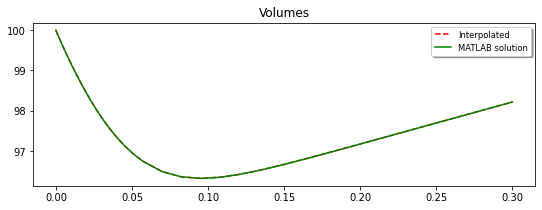


Extracellular Concentration: 21.25 e-3 
Parameter point [0. 0. 0. 0.]


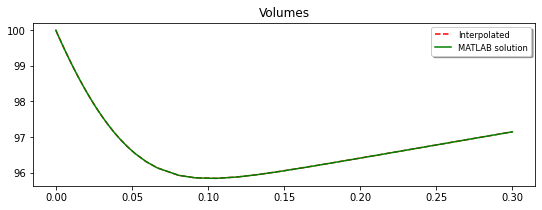


Extracellular Concentration: 37.5 e-3 
Parameter point [0. 0. 0. 0.]


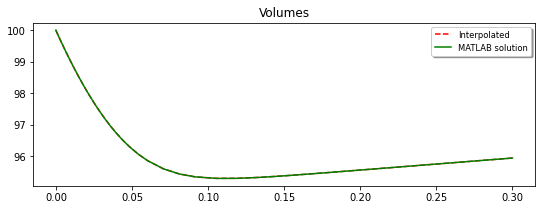


Extracellular Concentration: 53.75 e-3 
Parameter point [0. 0. 0. 0.]


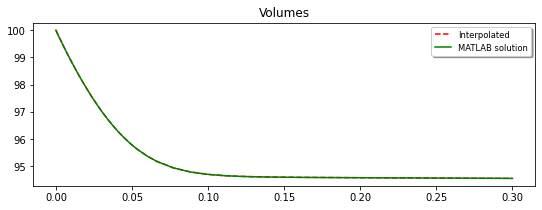


Extracellular Concentration: 70.0 e-3 
Parameter point [0. 0. 0. 0.]


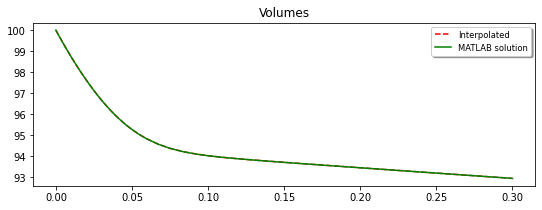

In [ ]:
pnka = 0 #1.7278759594743865e-06
pnkcc = 0 #3.4557519189487726e-07
pkcc = 0 #1.5707963267948966e-09
pncc = 0 #3.141592653589793e-08

parms = np.array([pnka,
                  pnkcc,
                  pkcc,
                  pncc])

for concen in y_concentrations_array:
    con_parm = np.append(concen,parms)
    index_int = find_parameter_arg(all_yo_rates,con_parm)

    print('\nExtracellular Concentration:',concen*1e3,'e-3',
          '\nParameter point', all_yo_rates[index_int,1:])

    plt.figure(figsize=(9,3))
    plt.plot(inter_time[:]/3600,
                inter_vol[index_int,:], 
                'r--', label='Interpolated')
    
    plt.plot(all_time[index_int,:len_volume_steps_array[index_int]+1]/3600, 
                normalized_volume[index_int,:len_volume_steps_array[index_int]+1], 
                'g-', label='MATLAB solution')
    
    plt.legend(loc='upper right', shadow=True, fontsize='small')
    plt.title('Volumes')
    plt.show()

**Note**: The equilibrium of volume is unclear in the last figure. Consider increasing the time interval to 0.5 hours or more.

## NKA on


Extracellular Concentration: 5.0 e-3 
Parameter point [1.72787596e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00]


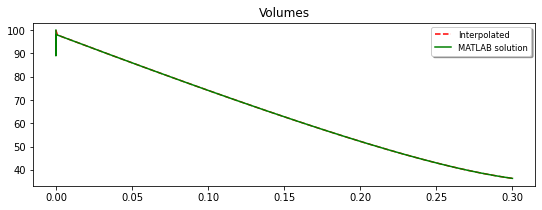


Extracellular Concentration: 21.25 e-3 
Parameter point [1.72787596e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00]


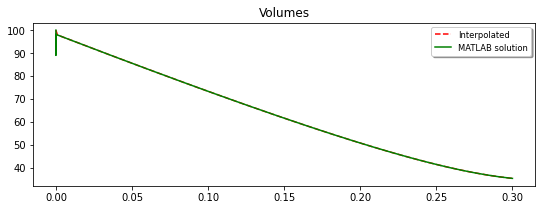


Extracellular Concentration: 37.5 e-3 
Parameter point [1.72787596e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00]


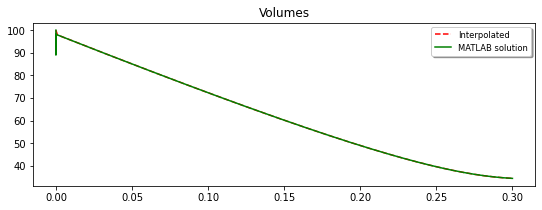


Extracellular Concentration: 53.75 e-3 
Parameter point [1.72787596e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00]


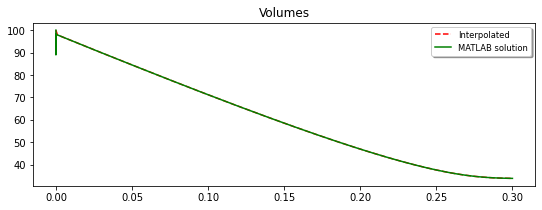


Extracellular Concentration: 70.0 e-3 
Parameter point [1.72787596e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00]


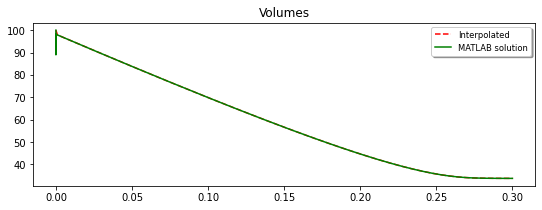

In [ ]:
pnka = 1.7278759594743865e-06
pnkcc = 0 #3.4557519189487726e-07
pkcc = 0 #1.5707963267948966e-09
pncc = 0 #3.141592653589793e-08

parms = np.array([pnka,
                  pnkcc,
                  pkcc,
                  pncc])

for concen in y_concentrations_array:
    con_parm = np.append(concen,parms)
    index_int = find_parameter_arg(all_yo_rates,con_parm)

    print('\nExtracellular Concentration:',concen*1e3,'e-3',
          '\nParameter point', all_yo_rates[index_int,1:])

    plt.figure(figsize=(9,3))
    plt.plot(inter_time[:]/3600,
                inter_vol[index_int,:], 
                'r--', label='Interpolated')
    
    plt.plot(all_time[index_int,:len_volume_steps_array[index_int]+1]/3600, 
                normalized_volume[index_int,:len_volume_steps_array[index_int]+1], 
                'g-', label='MATLAB solution')
    
    plt.legend(loc='upper right', shadow=True, fontsize='small')
    plt.title('Volumes')
    plt.show()

**Note**: NKA on appears to regulate volume sufficietly and convergence speed varies depending on excellular concentration. Volume initial decreases rapidly by ~$12\%$ then increases rapidly by ~$10\%$. By $0.3$ hours, volume appears to be at equilibrium, ~$33.78$, for all extracellular concentrations.

## NKCC on


Extracellular Concentration: 5.0 e-3 
Parameter point [0.00000000e+00 3.45575192e-07 0.00000000e+00 0.00000000e+00]


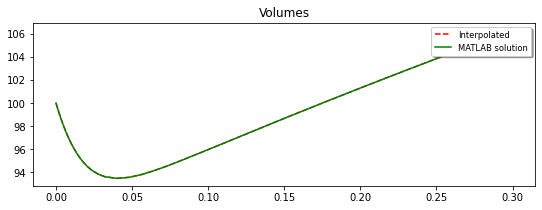


Extracellular Concentration: 21.25 e-3 
Parameter point [0.00000000e+00 3.45575192e-07 0.00000000e+00 0.00000000e+00]


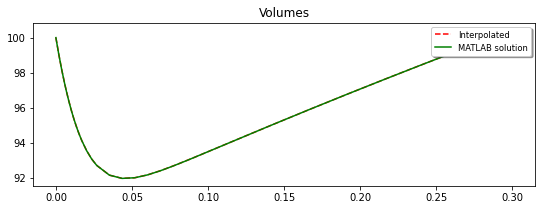


Extracellular Concentration: 37.5 e-3 
Parameter point [0.00000000e+00 3.45575192e-07 0.00000000e+00 0.00000000e+00]


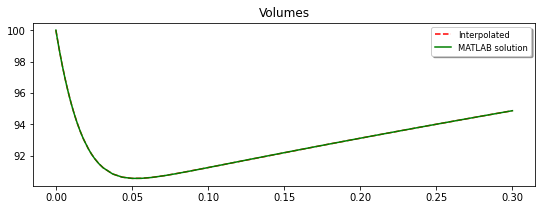


Extracellular Concentration: 53.75 e-3 
Parameter point [0.00000000e+00 3.45575192e-07 0.00000000e+00 0.00000000e+00]


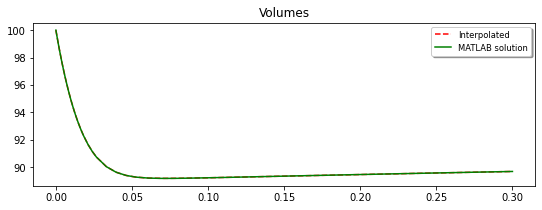


Extracellular Concentration: 70.0 e-3 
Parameter point [0.00000000e+00 3.45575192e-07 0.00000000e+00 0.00000000e+00]


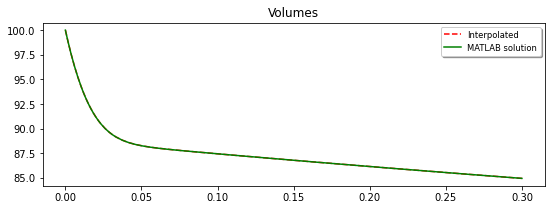

In [ ]:
pnka = 0 #1.7278759594743865e-06
pnkcc = 3.4557519189487726e-07
pkcc = 0 #1.5707963267948966e-09
pncc = 0 #3.141592653589793e-08

parms = np.array([pnka,
                  pnkcc,
                  pkcc,
                  pncc])

for concen in y_concentrations_array:
    con_parm = np.append(concen,parms)
    index_int = find_parameter_arg(all_yo_rates,con_parm)

    print('\nExtracellular Concentration:',concen*1e3,'e-3',
          '\nParameter point', all_yo_rates[index_int,1:])

    plt.figure(figsize=(9,3))
    plt.plot(inter_time[:]/3600,
                inter_vol[index_int,:], 
                'r--', label='Interpolated')
    
    plt.plot(all_time[index_int,:len_volume_steps_array[index_int]+1]/3600, 
                normalized_volume[index_int,:len_volume_steps_array[index_int]+1], 
                'g-', label='MATLAB solution')
    
    plt.legend(loc='upper right', shadow=True, fontsize='small')
    plt.title('Volumes')
    plt.show()


**Note**: Varying exratcellular concentration when NKCC is on is similar to when all transporters are off. However, when NKCC is on volume decreases by $10\% \pm 2.5$ by $0.05$ hours. By that time point, the equilibrium and convergence speed is unchanged. Notice that extracellular concentration $53.75 e-3$ when NKCC is on that volume overshoots its equilirbium and must begin increasing starting around $0.5$ hours.

## KCC on


Extracellular Concentration: 5.0 e-3 
Parameter point [0.00000000e+00 0.00000000e+00 1.57079633e-09 0.00000000e+00]


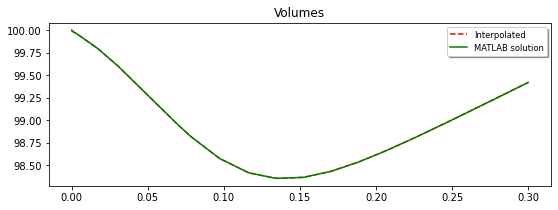


Extracellular Concentration: 21.25 e-3 
Parameter point [0.00000000e+00 0.00000000e+00 1.57079633e-09 0.00000000e+00]


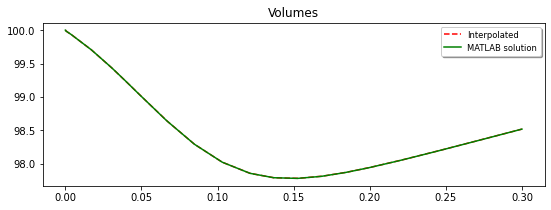


Extracellular Concentration: 37.5 e-3 
Parameter point [0.00000000e+00 0.00000000e+00 1.57079633e-09 0.00000000e+00]


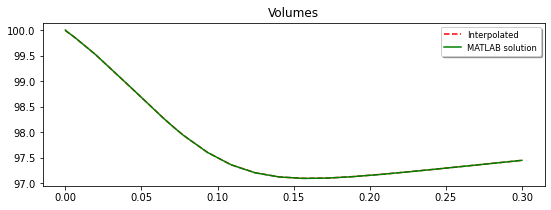


Extracellular Concentration: 53.75 e-3 
Parameter point [0.00000000e+00 0.00000000e+00 1.57079633e-09 0.00000000e+00]


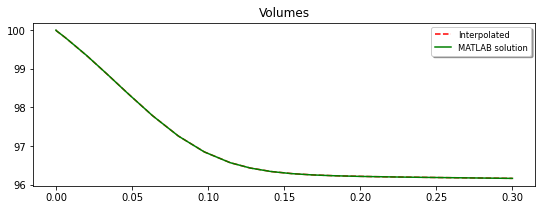


Extracellular Concentration: 70.0 e-3 
Parameter point [0.00000000e+00 0.00000000e+00 1.57079633e-09 0.00000000e+00]


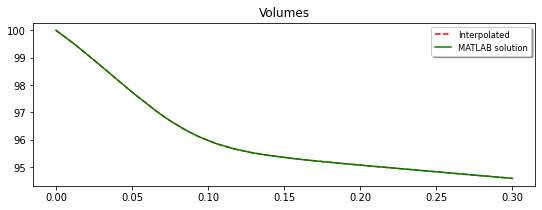

In [ ]:
pnka = 0 #1.7278759594743865e-06
pnkcc = 0 #3.4557519189487726e-07
pkcc = 1.5707963267948966e-09
pncc = 0 #3.141592653589793e-08

parms = np.array([pnka,
                  pnkcc,
                  pkcc,
                  pncc])

for concen in y_concentrations_array:
    con_parm = np.append(concen,parms)
    index_int = find_parameter_arg(all_yo_rates,con_parm)

    print('\nExtracellular Concentration:',concen*1e3,'e-3',
          '\nParameter point', all_yo_rates[index_int,1:])

    plt.figure(figsize=(9,3))
    plt.plot(inter_time[:]/3600,
                inter_vol[index_int,:], 
                'r--', label='Interpolated')
    
    plt.plot(all_time[index_int,:len_volume_steps_array[index_int]+1]/3600, 
                normalized_volume[index_int,:len_volume_steps_array[index_int]+1], 
                'g-', label='MATLAB solution')
    
    plt.legend(loc='upper right', shadow=True, fontsize='small')
    plt.title('Volumes')
    plt.show()

**Note**: Compared to the previous three cases, when KCC is turned on the volume decreases $5\% \pm 2.5\%$ before converging to its equilibrium after ~$0.14$ hours.

## NCC on


Extracellular Concentration: 5.0 e-3 
Parameter point [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.14159265e-08]


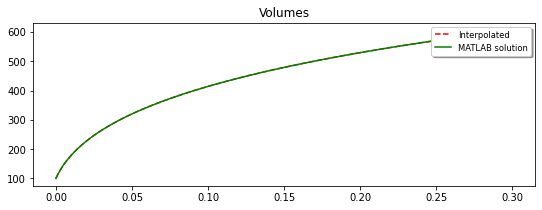


Extracellular Concentration: 21.25 e-3 
Parameter point [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.14159265e-08]


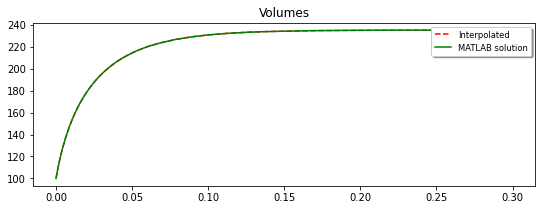


Extracellular Concentration: 37.5 e-3 
Parameter point [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.14159265e-08]


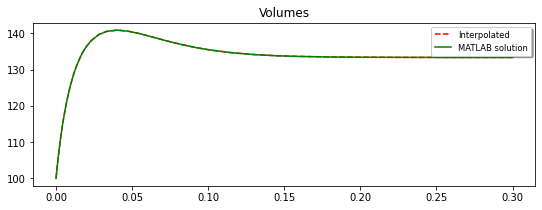


Extracellular Concentration: 53.75 e-3 
Parameter point [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.14159265e-08]


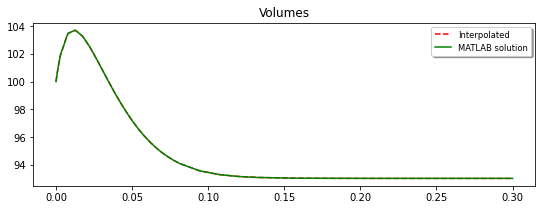


Extracellular Concentration: 70.0 e-3 
Parameter point [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.14159265e-08]


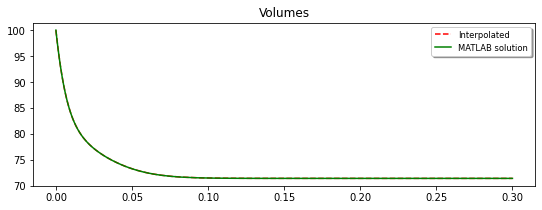

In [ ]:
pnka = 0 #1.7278759594743865e-06
pnkcc = 0 #3.4557519189487726e-07
pkcc = 0 #1.5707963267948966e-09
pncc = 3.141592653589793e-08

parms = np.array([pnka,
                  pnkcc,
                  pkcc,
                  pncc])

for concen in y_concentrations_array:
    con_parm = np.append(concen,parms)
    index_int = find_parameter_arg(all_yo_rates,con_parm)

    print('\nExtracellular Concentration:',concen*1e3,'e-3',
          '\nParameter point', all_yo_rates[index_int,1:])

    plt.figure(figsize=(9,3))
    plt.plot(inter_time[:]/3600,
                inter_vol[index_int,:], 
                'r--', label='Interpolated')
    
    plt.plot(all_time[index_int,:len_volume_steps_array[index_int]+1]/3600, 
                normalized_volume[index_int,:len_volume_steps_array[index_int]+1], 
                'g-', label='MATLAB solution')
    
    plt.legend(loc='upper right', shadow=True, fontsize='small')
    plt.title('Volumes')
    plt.show()

**Note**: When NCC is turned, volume makes an initial increase or decrease by varying amounts in the first $0.025$ hours. Only when extracelluar concentration is $70.0 e-3$ does the volume decrease in that time.